In [115]:
# __INIT__ 

import medleydb as mdb
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import pandas as pd
import IPython.display as ipd
import os
from os import path
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.preprocessing import label_binarize


#if not os.path.exists(os.path.join(path.dirname(__file__), 'data', 'preprocessed')):
#    os.makedirs(os.path.join(path.dirname(__file__), 'data', 'preprocessed'))

HOME_PATH = path.expanduser("~")
DATA_PATH = path.join(HOME_PATH, 'data', 'preprocessed')
MIX_PATH = path.join(HOME_PATH, 'data', 'mixes')

# Ändra till detta i en paketstruktur
#DATA_PATH = path.join(path.dirname(__file__), 'data', 'preprocessed')


# Based off of OpenMICs taxonomy discussions and the MedleyDB taxonomy yaml
OPENMIC_TO_MEDLEY = {"drums" : ["drum set"],
                     "bass" : ["electric bass", "double bass"],
                     "guitar" : ["distorted electric guitar", "clean electric guitar", "acoustic guitar"], 
                     "voice" : ["male singer", "female singer", "male speaker", "female speaker",
                                "male rapper", "female rapper", "beatboxing", "vocalists", "choir",
                                "male screamer", "female screamer"], 
                     "piano" : ["piano", "tack piano", "electric piano"],
                     "synthesizer" : ["synthesizer"],
                     #"organ" : ["pipe organ", "electric organ"],
                     #"accordion" : ["accordion"],
                     #"banjo" : ["banjo"], 
                     "cello" : ["cello", "cello section"], 
                     "clarinet" : ["clarinet", "clarinet section", "bass clarinet"], 
                     "cymbals" : ["cymbal"],
                     "flute" : ["flute", "dizi", "flute", "flute section", "piccolo",
                                "bamboo flute", "panpipes", "recorder"],
                     "mallet_percussion" : ["xylophone", "vibraphone", "glockenspiel", "marimba"],
                     "mandolin" : ["mandolin"],
                     "saxophone": ["alto saxophone", "baritone saxophone", "tenor saxophone", "soprano saxophone"], 
                     "trombone": ["trombone", "trombone section"], 
                     "trumpet" : ["trumpet", "trumpet section"],
                     #"ukulele" : ["ukulele"], 
                     "violin" : ["violin", "violin seciton"]} 

INSTRUMENTS = OPENMIC_TO_MEDLEY.keys()
INSTRUMENT_INDEX = {key : i for i, (key, _) in enumerate(OPENMIC_TO_MEDLEY.items())}

# INSTRUMENT_INDEX = {"drums" : 0,
#                      "bass" : 1,
#                      "guitar" : 2, 
#                      "voice" : 3, 
#                      "piano" : 4,
#                      "synthesizer" : 5,
#                      "organ" : 6,
#                      "accordion" : 7,
#                      "banjo" : 8, 
#                      "cello" : 9, 
#                      "clarinet" : 10, 
#                      "cymbals" : 11,
#                      "flute" : 12,
#                      "mallet_percussion" : 13,
#                      "mandolin" : 14,
#                      "saxophone": 15, 
#                      "trombone":16, 
#                      "trumpet" : 17,
#                      "ukulele" : 18, 
#                      "violin" : 19} 

MEDLEY_TO_OPENMIC = {v: k for k, v_list in OPENMIC_TO_MEDLEY.items() for v in v_list}
MEDLEY_TO_INDEX = {k: INSTRUMENT_INDEX[v] for k, v in MEDLEY_TO_OPENMIC.items()}
REV_INSTRUMENT_INDEX = {v: k for k, v in INSTRUMENT_INDEX.items()}

In [7]:
def load_track(track_id):
    t_gen = mdb.load_multitracks([track_id])
    return next(t_gen)
print(INSTRUMENTS)
t = load_track('MusicDelta_Shadows')
print(help(t))
print(t.stem_instruments)

dict_keys(['drums', 'bass', 'guitar', 'voice', 'piano', 'synthesizer', 'cello', 'clarinet', 'cymbals', 'flute', 'mallet_percussion', 'mandolin', 'saxophone', 'trombone', 'trumpet', 'violin'])
Help on MultiTrack in module medleydb.multitrack object:

class MultiTrack(builtins.object)
 |  MultiTrack(track_id)
 |  
 |  MultiTrack Class definition.
 |  
 |  This class loads all available metadata, annotations, and filepaths for a
 |  given multitrack directory.
 |  
 |  Parameters
 |  ----------
 |  track_id : str
 |      Track id in format 'Artist_Title'.
 |  
 |  Attributes
 |  ----------
 |  artist : str
 |      The artist of the multitrack
 |  title : str
 |      The title of the multitrack
 |  track_id : str
 |      The unique identifier of the multitrack. In the form 'Artist_Title'
 |  annotation_dir : str
 |      Path to multitrack's annotation directory
 |  audio_path : str
 |      Path to multitrack's top level audio directory
 |  mix_path : str
 |      Path to multitrack's mix fi

In [166]:
class Track(object):
    """ A track class invariant of medleyDBs multitrack. Contains information for pre-processing.
    
    To be used for pre-processing the minimal information needed is the following: 
        A trackID,
        A dictionary mapping stems to instruments, 
        A file path to the .wav-file
        And a path to the activation_conf file
        
    If a source_file doesn't exist it will be created in the pre-processing step. 
    """
    def __init__(self, track, data_type = 'train'):
        """
        Args:
            track (medleydb.MultiTrack or str): Pass either a MultiTrack or the path of a mix.
            data_type (str): To specify if the track should be used for training, testing, validation or non-labeled.
        """
        if isinstance(track, mdb.MultiTrack):
            self.track_id = track.track_id
            
            self.instruments, self.stem_instruments = self.extract_instruments(track)
            
            assert os.path.exists(track.mix_path), "%s does not exist" % track.mix_path
            self.mix_path = track.mix_path
                
            if os.path.exists(track.activation_conf_v2_fpath):   
                self.activation_conf_path = track.activation_conf_v2_fpath
            elif os.path.exists(track.activation_conf_fpath): 
                self.activation_conf_path = track.activation_conf_fpath
            else: 
                raise Exception("no activation_conf files found")
            
            # If no source, we create it in preprocessing step
            if os.path.exists(track.source_id_fpath):
                self.source_path = track.source_id_fpath
            else: 
                self.source_path = None
            
            self.is_medley = True
            self.data_type = data_type
                
        else: 
            self.track_id = track
            
            assert os.path.exists(os.path.join(MIX_PATH, track, "metadata.npy")), "%s does not exist" % os.path.join(MIX_PATH, track, "metadata.npy")
            self.stem_instruments = np.load(os.path.join(MIX_PATH, track, stem_instruments.npy), allow_pickle=True).item() 
            
            assert os.path.exists(os.path.join(MIX_PATH, track, "%s.wav" % track)), "%s does not exist" % os.path.join(MIX_PATH, track, "%s.wav"%track) 
            self.mix_path = os.path.join(MIX_PATH, track, "%s.wav" % track)
            
            if data_type != "non-labeled":
                assert os.path.exists(os.path.join(MIX_PATH, track, "activation_conf.csv")), "%s does not exist" % os.path.join(MIX_PATH, track, "activation_conf.csv")  
                self.activation_conf_path = os.path.join(MIX_PATH, track, "activation_conf.csv")
            
            # If no source, we create it in preprocessing step
            if os.path.exists(os.path.join(MIX_PATH, track, "source.csv")):
                self.source_path = os.path.join(MIX_PATH, track, "source.csv")
            else:
                self.source_path = None
                
            self.is_medley = False
            self.data_type = data_type
    
    
    def extract_instruments(self, t):
        instruments = {MEDLEY_TO_OPENMIC[i] for i in t.stem_instruments if i in MEDLEY_TO_OPENMIC.keys()}
        stem_instruments = {self.generate_stem_key(k): medleys_to_openmic(v.instrument) for k, v in t.stems.items() if v.instrument in MEDLEY_TO_OPENMIC.keys()}
        return instruments, stem_dict 
    
    def medleys_to_openmic(self, instruments):
        return [MEDLEY_TO_OPENMIC[i] for i in instruments if i in MEDLEY_TO_OPENMIC.keys()]
    
    def generate_stem_key(self, x):
        if x < 10:
            return "S0%d" % x
        else:
            return "S%d" % x

In [167]:
track = Track(load_track('MusicDelta_Shadows'))

TypeError: unhashable type: 'list'

In [149]:
def generate_id(x):
    return "%d".rjust(5, "0") % x 

def extract_stem_instruments(t):
    return {generate_stem_key(k): v.instrument for k, v in t.stems.items()}

def generate_stem_key(x):
    if x < 10:
        return "S0%d" % x
    else:
        return "S%d" % x

def create_spectrogram(track, spectrogram_len, n_fft, hop_length, n_mels):
    y, sr = librosa.load(track.mix_path)
    samples_per_spectrogram = int(sr*spectrogram_len)
    num_spectrograms = len(y)//samples_per_spectrogram 
    # Remove samples that doesn't divide equally with s_p_s
    y = y[:num_spectrograms*samples_per_spectrogram]
    spectrograms = []
    # could optimize by saving spectrograms directly here
    # however imo code is cleaner if saved in helper func
    for i in range(0, len(y), samples_per_spectrogram):
        sound_bite = y[i:i+samples_per_spectrogram]
        S = librosa.feature.melspectrogram(y=sound_bite, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        S_dB = librosa.power_to_db(S, ref=np.max).astype(np.float32)
        spectrograms.append(S_dB)    
    spectrograms = np.stack(spectrograms, axis=0)
    return spectrograms
    
def preprocess_spectrogram_labels(iad_path, num_spectrograms, spectrogram_len=1):
    time_cutoff = num_spectrograms*spectrogram_len
    #Rows = which spectrogram, Cols = Which instrument
    instrument_annotations = np.zeros((num_spectrograms, len(INSTRUMENTS)))
    annotations = pd.read_csv(iad_path)
    for index, row in annotations.iterrows():
        instrument = row["instrument_label"]
        if instrument in INSTRUMENTS:
            s_t = row["start_time"]
            e_t = row["end_time"]
            if e_t > time_cutoff: 
                e_t = time_cutoff
            d_t = e_t - s_t
            s_i = int(s_t//spectrogram_len)
            e_i = int(e_t//spectrogram_len)
            #print("instrument: ", instrument, "(%s)" % INSTRUMENT_INDEX[instrument])
            #print("start index: ", s_i)
            #print("end index: ", e_i, "\n") 
            for i in range(s_i, e_i):
                instrument_annotations[i][INSTRUMENT_INDEX[instrument]] = 1
    
    return instrument_annotations
    # np.set_printoptions(threshold=np.inf)
    # print(instrument_annotations)
    
def create_source_from_activations(t): 
    conf_df = pd.read_csv(t.activation_conf_path)
    columns = conf_df.columns
    num_instruments = len(columns)
    start_time = [0] * num_instruments
    new_bin = [False] * num_instruments
    source_activations = [] 
    # TODO: should be extracted already in t
    s_i = extract_stem_instruments(t)
    for index, row in conf_df.iterrows():
        time = row[0]
        stem = 1
        for conf in row[1:]:
            if not conf >= 0.5 and new_bin[stem]:
                new_bin[stem] = False
                for instrument_label in s_i[columns[stem]]: 
                    source_activations.append((start_time[stem], time-0.0464, instrument_label))
            if conf >= 0.5 and not new_bin[stem]:
                new_bin[stem] = True
                start_time[stem] = time
            stem += 1
            
    source_df = pd.DataFrame(source_activations, columns=['start_time', 'end_time', 'instrument_label']) 
    source_df = source_df.sort_values(by=['instrument_label'])
    
    homedir = os.path.expanduser("~")
    # Top level directory will look like "spectrogram-len_n-fft_hop-length"
    base_path = os.path.join(homedir, "data/processed/source_ids")
    
    if not(os.path.exists(base_path)):
            os.makedirs(base_path)    
    
    source_df.to_csv(path_or_buf = os.path.join(base_path, "%s_SOURCEID.lab" % t.track_id), index=False, float_format='%.4f')
    t.source_path = os.path.join(base_path, "%s_SOURCEID.lab" % t.track_id)

def preprocess_track(track, spectrogram_len=1, n_fft=2048, hop_length=512, n_mels=128):
    spectograms = create_spectrograms(track, spectrogram_len, n_fft, hop_length, n_mels)
    number_of_spectrograms = spectrograms.shape[0]
   
    if track.data_type == "non-labeled":
        for i in range(number_of_spectrograms):
            spectrogram = spectrograms[i]
            # Each spectrogram with corresponding label will look like "trackid_idx_mel/label"
            np.save(os.path.join(input_path, "%s_%d.npy" % (track.track_id, i)), spectrogram)       
    else:
        if track.source_path is None:
            create_source_from_activations(track)
        labels = preprocess_labels(track, number_of_spectrograms, spectrogram_len)

        for i in range(number_of_spectrograms):
            spectrogram = spectrograms[i]
            label = labels[i]
            # Each spectrogram with corresponding label will look like "trackid_idx_mel/label"
            np.save(os.path.join(input_path, "%s_%d.npy" % (track.track_id, generate_id(i))), spectrogram)
            np.save(os.path.join(label_path, "%s_%d.npy" % (track.track_id, generate_id(i))), label)

def preprocess_tracks(test_size = 0.2, val_size = 0.2, dataset_version = ['V1', 'V2'], path_to_mixes = None, path_to_nonlabeled = None):
    train, val, test = create_train_val_test_split(dataset_version, test_size = test_size, val_size = val_size)
    
def instruments_for_track(track, songs):
    instruments = np.zeros(len(INSTRUMENT_INDEX)) 
    for i in track.stem_instruments:
        if i in MEDLEY_TO_OPENMIC.keys():
            i = INSTRUMENT_INDEX[MEDLEY_TO_OPENMIC[i]]
            if not instruments[i]:
                instruments[i] = 1
                songs[i].add(track.track_id)
    return instruments

def instrument_dist(tracks):
    songs = [set()] * len(INSTRUMENT_INDEX)
    instruments = np.zeros(len(INSTRUMENT_INDEX))
    for t in tracks: 
        instruments += instruments_for_track(t, songs)
    print(songs)
    return instruments

def medley_to_openmic(instruments): 
    return [MEDLEY_TO_OPENMIC[i] for i in instruments if i in MEDLEY_TO_OPENMIC.keys()]

# GÖR INVARIANT TILL MEDLEY...
from sklearn.preprocessing import MultiLabelBinarizer
def create_train_val_test_split(dataset_version=["V1","V2"], test_size = 0.2, val_size = 0.2):
    tracks = mdb.load_all_multitracks(dataset_version)
    X = []
    Y = []
    
    for t in tracks: 
        if os.path.exists(t.activation_conf_fpath) or os.path.exists(t.activation_conf_v2_fpath):
            instruments = medley_to_openmic(t.stem_instruments)
            valid_instruments = list(set(instruments).intersection(INSTRUMENTS))
            all_valid_instruments = list(INSTRUMENTS)
            if len(valid_instruments) > 0: 
                X.append(t.track_id)
                Y.append(valid_instruments)
    
    mlb = MultiLabelBinarizer(list(INSTRUMENTS))
    Y = mlb.fit_transform(Y)
    import sys
    np.set_printoptions(threshold=sys.maxsize)
    X = np.array(X)
    
    test_train = MultilabelStratifiedShuffleSplit(n_splits=2, test_size = test_size, random_state=0)
    
    for train_index, test_index in test_train.split(X, Y):
        X_train, test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        break
    
    train_val = MultilabelStratifiedShuffleSplit(n_splits=2, test_size = val_size, random_state=0)

    for train_index, test_index in train_val.split(X_train, Y_train):
        train, val = X_train[train_index], X_train[test_index]
        train_labels, val_labels = Y_train[train_index], Y_train[test_index]
        break
        
    print("Training sample length:", train.shape[0])
    print("Distribution:", np.sum(train_labels, axis=0))
    print("Validation sample length:", val.shape[0])
    print("Distribution:", np.sum(val_labels, axis=0))
    print("Test sample length", test.shape[0])
    print("Distribution:", np.sum(Y_test, axis=0))
    
    return train, val, test
    

In [150]:
create_train_val_test_split()

/home/carlnys/data/medleydb/medleydb/multitrack.py:367: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  metadata = yaml.load(f_in)


Training sample length: 90
Distribution: [55 61 49 52 40 18  8  7  5 11  8  6  4  2  8 11]
Validation sample length: 23
Distribution: [14 15 12 13 10  5  2  2  1  3  2  1  1  1  2  3]
Test sample length 31
Distribution: [18 22 19 16 12  6  3  2  1  3  2  2  1  1  2  4]


(array(['AClassicEducation_NightOwl', 'AimeeNorwich_Child',
        'AimeeNorwich_Flying', 'AmarLal_Rest', 'AmarLal_SpringDay1',
        'AvaLuna_Waterduct', 'BigTroubles_Phantom',
        'BrandonWebster_DontHearAThing', 'ChrisJacoby_PigsFoot',
        'ClaraBerryAndWooldog_AirTraffic', 'ClaraBerryAndWooldog_Boys',
        'ClaraBerryAndWooldog_TheBadGuys', 'Debussy_LenfantProdigue',
        'DreamersOfTheGhetto_HeavyLove',
        'EthanHein_1930sSynthAndUprightBass', 'EthanHein_BluesForNofi',
        'EthanHein_GirlOnABridge', 'EthanHein_HarmonicaFigure',
        'FamilyBand_Again', 'HeladoNegro_MitadDelMundo',
        'HezekiahJones_BorrowedHeart',
        'InvisibleFamiliars_DisturbingWildlife', 'JoelHelander_Definition',
        'KarimDouaidy_Hopscotch', 'LizNelson_Coldwar',
        'LizNelson_ImComingHome', 'Lushlife_ToynbeeSuite',
        'MatthewEntwistle_AnEveningWithOliver',
        'MatthewEntwistle_FairerHopes', 'MatthewEntwistle_Lontano',
        'MatthewEntwistle_TheFlax

In [18]:
def load_track(track_id):
    t_gen = mdb.load_multitracks([track_id])
    return next(t_gen)


# Gör preprocess_track invariant till medley-data, det enda som behövs är:
#      - ett unikt id
#      - path till en ljudfil
#      - path till antingen en source, eller till activation_confs
#      - vilka instrument som spelar i låten (och som hör till vilken stem):  
#              detta som en dict, eg: {"S01" : "piano"}
#      - Om låten är träning, validation, testing eller non-supervised
#
# Givet informationen ovan, funktionen som mixar stems bör alltså skapa:
#      - ett unikt id
#      - en mixad ljudfil
#      - en activation conf file med tillhörande...
#      - metadata kring vilka instrument som mappar till vilken stem
# 
# Below follows outlines with track dependencies
#
# def outline_ppt(track, spec_length=1, n_fft=2048, hop_length=512, n_mels=128):
#     spectrograms = create_spectrograms(track)
#     
#     if os.path.isfile(track.source_id_fpath):
#         iad_path = track.source_id_fpath
#     else:
#         iad_path = create_source_from_activations(t, stems=None)
#     
#     if not os.path.isfile(path.join(DATA_PATH, spec_length, labels):
#         labels = preprocess_spectrogram_labels(iad_path, num_spectrograms, spectrogram_len)
#     
# def outline_create_spec(track, spec_options): 
#     librosa.load(track.path)
#                                                
# def outline_preprocess_labels():
#     pd.load(track.sourcepath)
# 
# def outline_source_from_activations():
#     pd.load(track.activationpath)
#     t.instrument_stem_dict

# TODO: Check train/val/test split 
# Left to determine is how to create the track-class based off of either medley or custom 
# def preprocess_tracks(medley_tracks, mix_tracks):
#     tracks = []   
#     for t in medley_tracks:
#         tracks.append(Track(t.trackID, t.mixpath, t.activation_path, t.source_id, t.stems.instruments))
#     for t in mix_tracks:
#         t = load_dir(path.join(MIX_PATH, t))
#         tracks.append(Track(t.trackID, t.mixpath, t.activation_path, t.source_id, t.stems.instruments))

def preprocess_track(track, spectrogram_len=1, n_fft=2048, hop_length=512, n_mels=128):
    y, sr = librosa.load(track.mix_path)
    samples_per_spectrogram = int(sr*spectrogram_len)
    num_spectrograms = len(y)//samples_per_spectrogram 
    # Remove samples that doesn't divide equally with s_p_s
    y = y[:num_spectrograms*samples_per_spectrogram]
    spectrograms = []
    for i in range(0, len(y), samples_per_spectrogram):
        sound_bite = y[i:i+samples_per_spectrogram]
        S = librosa.feature.melspectrogram(y=sound_bite, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        S_dB = librosa.power_to_db(S, ref=np.max).astype(np.float32)
        spectrograms.append(S_dB)
        
    spectrograms = np.stack(spectrograms, axis=0)
    
    if os.path.isfile(track.source_id_fpath):
        iad_path = track.source_id_fpath
    else:
        iad_path = os.path.join(source_path, "%s_SOURCEID.lab" % t.trackid)
    
    labels = preprocess_spectrogram_labels(iad_path, num_spectrograms, spectrogram_len)
    
    # Top level directory will look like "spectrogram-len_n-fft_hop-length"
    spec_path = os.path.join(homedir, "data/processed/%d_%d_%d/" % (spectrogram_len, n_fft, hop_length))
    input_path = os.path.join(spec_path, "input")
    label_path = os.path.join(spec_path, "labels")
    
    if not(os.path.exists(input_path)):
        os.makedirs(input_path)    
    if not(os.path.exists(label_path)):
        os.makedirs(label_path) 
        
    for i in range(num_spectrograms):
        spectrogram = spectrograms[i]
        label = labels[i]
        # Each spectrogram with corresponding label will look like "trackid_idx_mel/label"
        np.save(os.path.join(input_path, "%s_%d.npy" % (track.track_id, i)), spectrogram)
        np.save(os.path.join(label_path, "%s_%d.npy" % (track.track_id, i)), label)
    #return mels, labels
    
def preprocess_non_medley_track(track, spectrogram_len=1, n_fft=2048, hop_length=512, n_mels=128):
    homedir = os.path.expanduser("~")
    path = os.path.join(homedir, "data/es_data", "%s.wav" % track)
    y, sr = librosa.load(path)
    samples_per_spectrogram = int(sr*spectrogram_len)
    num_spectrograms = len(y)//samples_per_spectrogram 
    # Remove samples that doesn't divide equally with s_p_s
    y = y[:num_spectrograms*samples_per_spectrogram]
    spectrograms = []
    for i in range(0, len(y), samples_per_spectrogram):
        sound_bite = y[i:i+samples_per_spectrogram]
        S = librosa.feature.melspectrogram(y=sound_bite, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        S_dB = librosa.power_to_db(S, ref=np.max).astype(np.float32)
        spectrograms.append(S_dB)
        
    spectrograms = np.stack(spectrograms, axis=0)
    #if os.path.isfile(track.source_id_fpath):
    #    iad_path = track.source_id_fpath
    #else:
    #    iad_path = os.path.join(source_path, "%s_SOURCEID.lab" % t.trackid)
    #
    #labels = preprocess_spectrogram_labels(iad_path, num_spectrograms, spectrogram_len)
    #
    ## Top level directory will look like "spectrogram-len_n-fft_hop-length"
    #spec_path = os.path.join(homedir, "data/processed/%d_%d_%d/" % (spectrogram_len, n_fft, hop_length))
    #input_path = os.path.join(spec_path, "input")
    #label_path = os.path.join(spec_path, "labels")
    
    spec_path = os.path.join(homedir, "data/processed/non_medley/%d_%d_%d/" % (spectrogram_len, n_fft, hop_length))
    input_path = os.path.join(spec_path, track, "input")
    
    if not(os.path.exists(input_path)):
        os.makedirs(input_path)    
    
    for i in range(num_spectrograms):
        spectrogram = spectrograms[i]
        #label = labels[i]
        # Each spectrogram with corresponding label will look like "trackid_idx_mel/label"
        np.save(os.path.join(input_path, "%s_%s.npy" % (track, generate_id_idx(i))), spectrogram)
        #np.save(os.path.join(label_path, "%s_%d.npy" % (track.track_id, i)), label)
    #return mels, labels
    
def preprocess_spectrogram_labels(iad_path, num_spectrograms, spectrogram_len=1):
    time_cutoff = num_spectrograms*spectrogram_len
    #Rows = which spectrogram, Cols = Which instrument
    instrument_annotations = np.zeros((num_spectrograms, len(INSTRUMENTS)))
    annotations = pd.read_csv(iad_path)
    for index, row in annotations.iterrows():
        instrument = row["instrument_label"]
        if instrument in INSTRUMENTS:
            s_t = row["start_time"]
            e_t = row["end_time"]
            if e_t > time_cutoff: 
                e_t = time_cutoff
            d_t = e_t - s_t
            s_i = int(s_t//spectrogram_len)
            e_i = int(e_t//spectrogram_len)
            #print("instrument: ", instrument, "(%s)" % INSTRUMENT_INDEX[instrument])
            #print("start index: ", s_i)
            #print("end index: ", e_i, "\n") 
            for i in range(s_i, e_i):
                instrument_annotations[i][INSTRUMENT_INDEX[instrument]] = 1
    
    return instrument_annotations
    # np.set_printoptions(threshold=np.inf)
    # print(instrument_annotations)

def generate_stem_key(x):
    if x < 10:
        return "S0%d" % x
    else:
        return "S%d" % x
    
def generate_id_idx(x):
    if x < 10:
        return "00%d" % x
    elif x < 100:
        return "0%d" % x
    else:
        return x
    
def extract_stem_instruments(t):
    return {generate_stem_key(k): v.instrument for k, v in t.stems.items()}
    
def create_source_from_activations(t): 
    conf_df = pd.read_csv(t.activation_conf_path)
    columns = conf_df.columns
    num_instruments = len(columns)
    start_time = [0] * num_instruments
    new_bin = [False] * num_instruments
    source_activations = [] 
    s_i = extract_stem_instruments(t)
    for index, row in conf_df.iterrows():
        time = row[0]
        stem = 1
        for conf in row[1:]:
            if not conf >= 0.5 and new_bin[stem]:
                new_bin[stem] = False
                for instrument_label in s_i[columns[stem]]: 
                    source_activations.append((start_time[stem], time-0.0464, instrument_label))
            if conf >= 0.5 and not new_bin[stem]:
                new_bin[stem] = True
                start_time[stem] = time
            stem += 1
            
    source_df = pd.DataFrame(source_activations, columns=['start_time', 'end_time', 'instrument_label']) 
    source_df = source_df.sort_values(by=['instrument_label'])
    
    homedir = os.path.expanduser("~")
    # Top level directory will look like "spectrogram-len_n-fft_hop-length"
    base_path = os.path.join(homedir, "data/processed/source_ids")
    
    if not(os.path.exists(base_path)):
            os.makedirs(base_path)    
    
    source_df.to_csv(path_or_buf = os.path.join(base_path, "%s_SOURCEID.lab" % t.track_id), index=False, float_format='%.4f')
    t.source_path = os.path.join(base_path, "%s_SOURCEID.lab" % t.track_id)
    
def preprocess_all_data(datasets = ['V1', 'V2']):
    track_generator = mdb.load_all_multitracks(datasets)
    count = 1
    for t in track_generator:
        if os.path.isfile(t.mix_path) and (os.path.isfile(t.source_id_fpath) or os.path.isfile(os.path.join(source_path, "%s_SOURCEID.lab"))):
            preprocess_track(t)
            count += 1
        else:
            print ("File does not exist: ", t.track_id)
        print("Processing track: %d" % count, end="\r")
        
def all_activations_to_source(datasets = ['V1', 'V2']):
    track_generator = mdb.load_all_multitracks(datasets)
    count = 1
    for t in track_generator:
        print("Track_ID: %s Count: %d" % (t.track_id.ljust(50, " "), count), end="\r")
        if os.path.isfile(t.activation_conf_v2_fpath) or os.path.isfile(t.activation_conf_fpath):
            create_source_from_activations(t)
            count += 1
        else:
            print ("File does not exist: ", t.activation_conf_v2_fpath)

In [ ]:
play_audio(load_track(''))

In [2]:
preprocess_all_data()

/home/carlnys/data/medleydb/medleydb/multitrack.py:367: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  metadata = yaml.load(f_in)


/home/carlnys/data/medleydb/medleydb/multitrack.py:367: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  metadata = yaml.load(f_in)
/home/carlnys/.local/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


/home/carlnys/data/medleydb/medleydb/multitrack.py:367: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  metadata = yaml.load(f_in)


File does not exist:  Allegria_MendelssohnMovement1
File does not exist:  AmadeusRedux_MozartAllegro
File does not exist:  AmadeusRedux_SchubertMovement2
File does not exist:  AmadeusRedux_SchubertMovement3
File does not exist:  BarefootSisters_RedJetta
File does not exist:  CassandraJenkins_PerfectDay
File does not exist:  CatMartino_IPromise
File does not exist:  Cayetana_MissThing
File does not exist:  DahkaBand_SoldierMan
File does not exist:  DeadMilkmen_PrisonersCinema
File does not exist:  DeclareAString_MendelssohnPianoTrio1Movement1
File does not exist:  DeclareAString_MendelssohnPianoTrio1Movement2
File does not exist:  FallingSparks_Improvisation1
File does not exist:  FallingSparks_Improvisation2
File does not exist:  FallingSparks_Improvisation3
File does not exist:  FallingSparks_PakKlongTalad
File does not exist:  FennelCartwright_DearTessie
File does not exist:  FennelCartwright_FlowerDrumSong
File does not exist:  FennelCartwright_WinterLake
File does not exist:  Filth

In [96]:
track = load_track('MusicDelta_Shadows')
preprocess_track(track)

/home/carlnys/data/processed/MusicDelta_Shadows/1/mels.npy


In [68]:
#REV_INSTRUMENT_INDEX[3]
spectrogram_len=1
print('/home/carlnys/data/processed/%s/%s/mels.npy' % (track.track_id, spectrogram_len))

/home/carlnys/data/processed/MusicDelta_Shadows/1/mels.npy


Instruments playing: drum set , electric bass , clean electric guitar , 

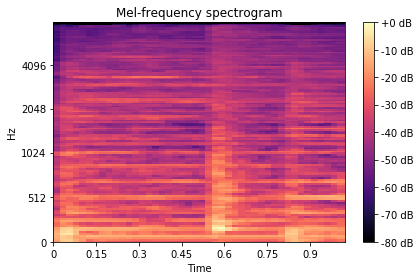

Instruments playing: drum set , electric bass , clean electric guitar , 

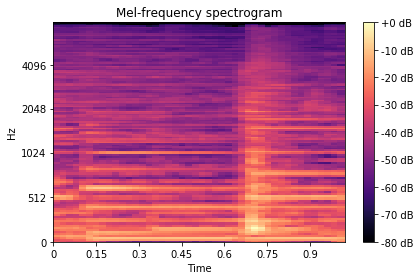

Instruments playing: drum set , electric bass , clean electric guitar , 

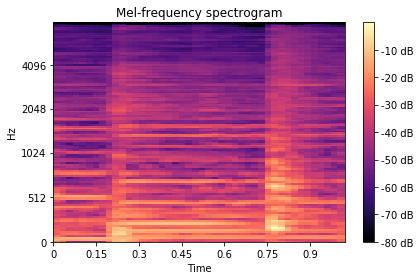

Instruments playing: drum set , electric bass , clean electric guitar , 

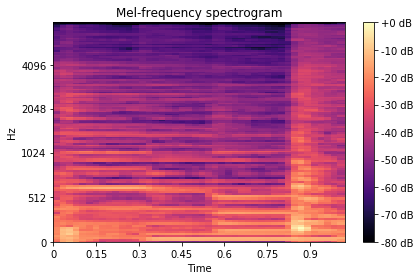

Instruments playing: drum set , electric bass , clean electric guitar , 

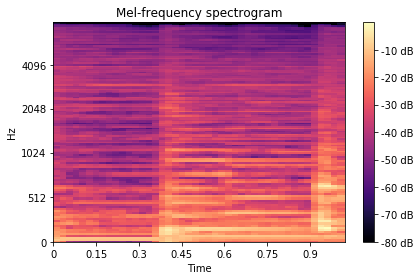

Instruments playing: drum set , electric bass , clean electric guitar , 

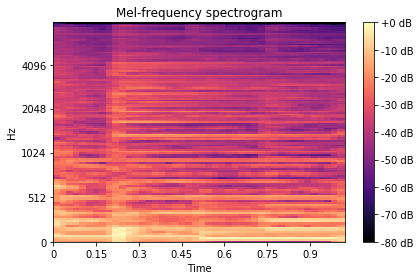

Instruments playing: drum set , electric bass , clean electric guitar , 

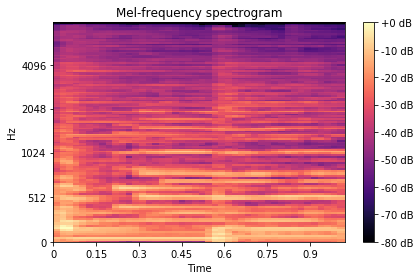

Instruments playing: drum set , electric bass , clean electric guitar , 

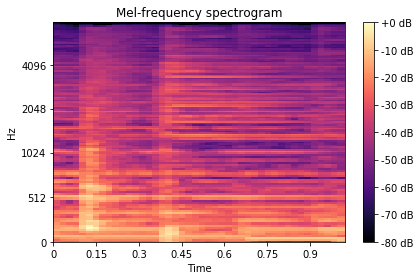

Instruments playing: drum set , electric bass , clean electric guitar , 

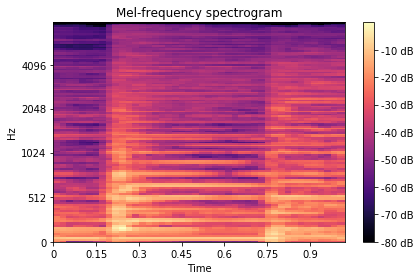

Instruments playing: drum set , electric bass , clean electric guitar , 

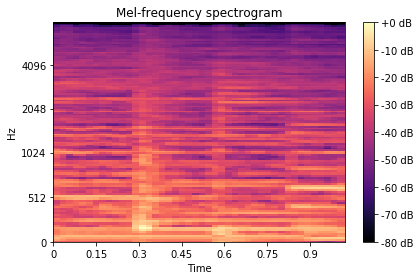

Instruments playing: drum set , electric bass , clean electric guitar , 

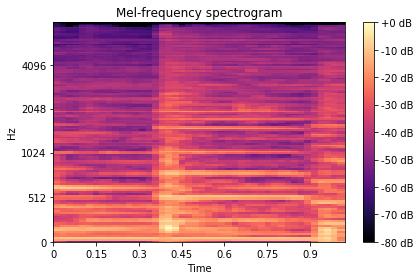

Instruments playing: drum set , electric bass , clean electric guitar , 

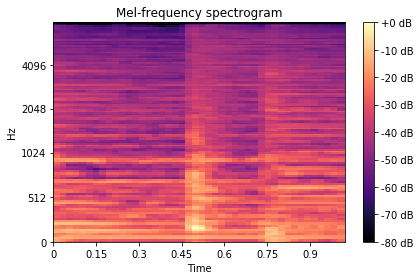

Instruments playing: drum set , electric bass , clean electric guitar , 

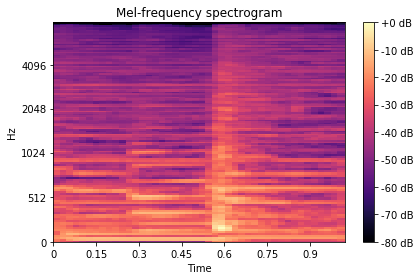

Instruments playing: drum set , electric bass , clean electric guitar , 

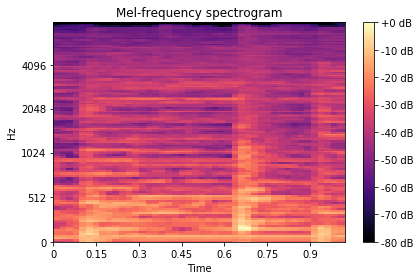

Instruments playing: drum set , electric bass , clean electric guitar , 

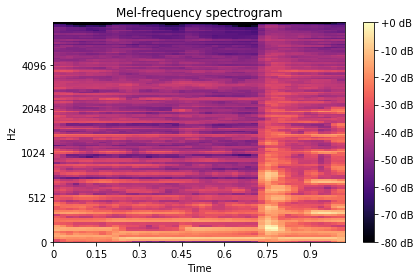

Instruments playing: drum set , electric bass , clean electric guitar , 

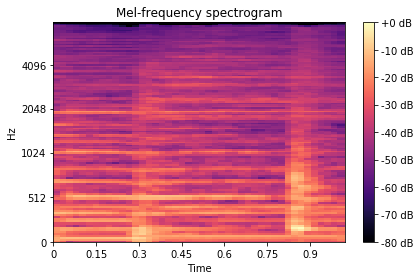

Instruments playing: drum set , electric bass , clean electric guitar , 

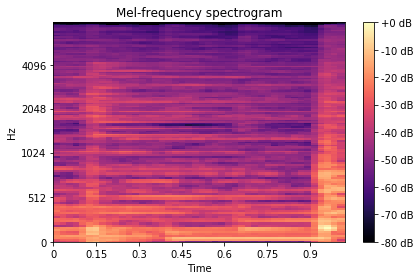

Instruments playing: drum set , electric bass , clean electric guitar , 

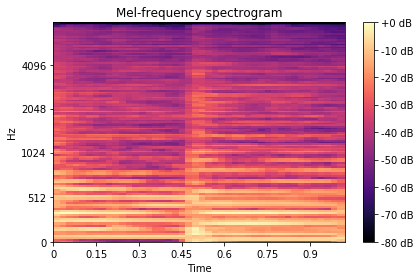

Instruments playing: drum set , electric bass , clean electric guitar , 

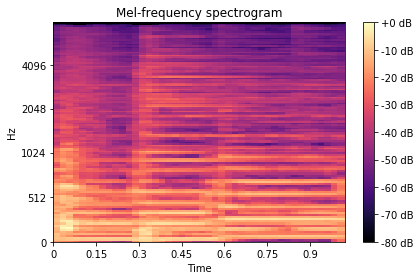

Instruments playing: drum set , electric bass , clean electric guitar , 

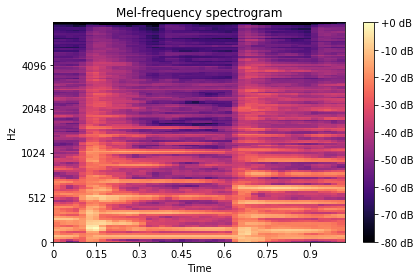

Instruments playing: drum set , electric bass , clean electric guitar , 

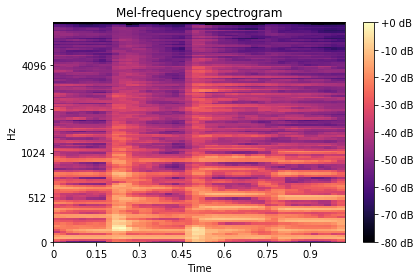

Instruments playing: drum set , electric bass , clean electric guitar , 

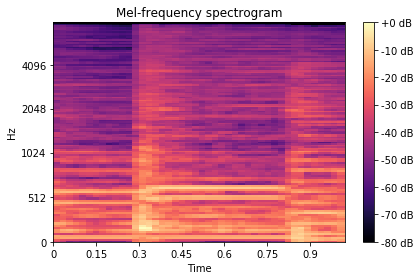

Instruments playing: drum set , electric bass , clean electric guitar , 

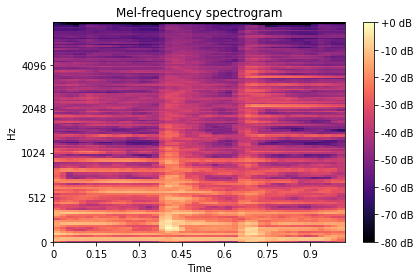

Instruments playing: drum set , electric bass , clean electric guitar , 

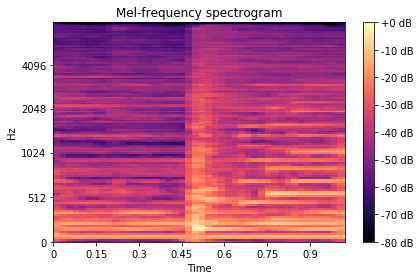

Instruments playing: drum set , electric bass , clean electric guitar , 

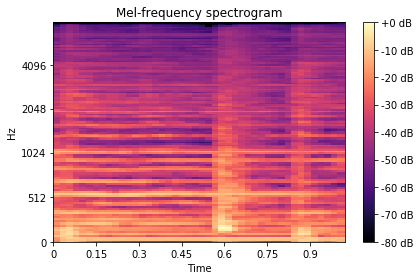

Instruments playing: drum set , electric bass , clean electric guitar , 

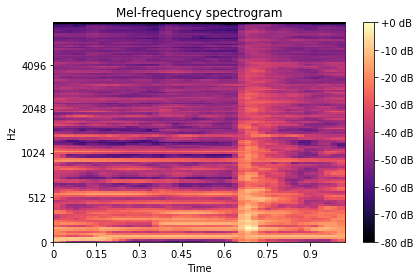

Instruments playing: drum set , electric bass , clean electric guitar , 

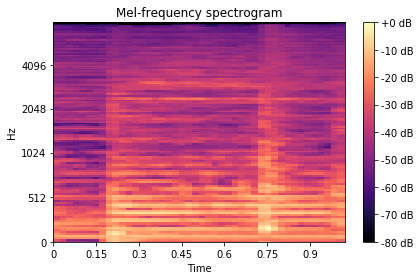

Instruments playing: drum set , electric bass , clean electric guitar , 

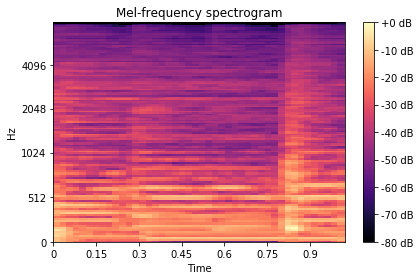

Instruments playing: drum set , electric bass , clean electric guitar , 

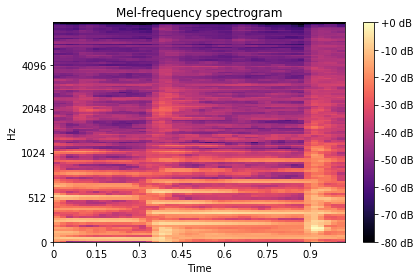

Instruments playing: drum set , electric bass , clean electric guitar , 

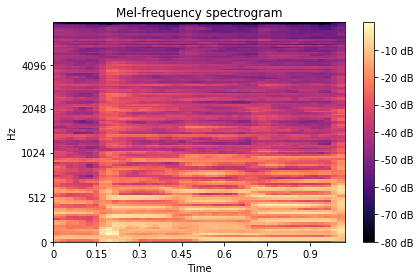

Instruments playing: drum set , electric bass , clean electric guitar , 

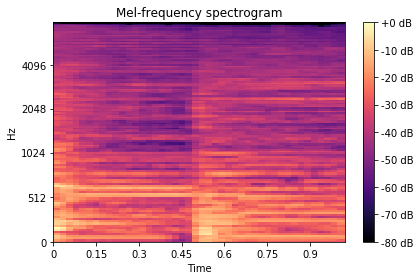

Instruments playing: drum set , electric bass , clean electric guitar , 

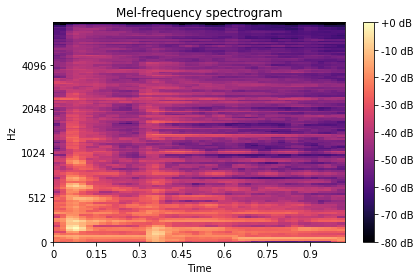

Instruments playing: drum set , electric bass , clean electric guitar , 

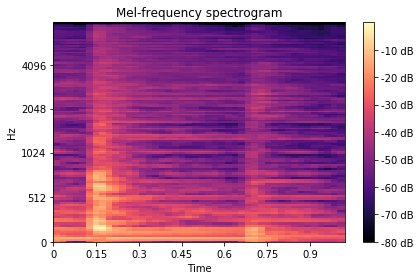

In [64]:
for i in range(specs.shape[0]):
        print("Instruments playing: ", end ='')
        for l in range(labels.shape[1]):
            if labels[i][l] == 1:
                print(REV_INSTRUMENT_INDEX[l], ", ", end = '')
        librosa.display.specshow(specs[i], x_axis='time',
                         y_axis='mel', sr=22050,
                         hop_length=512,
                         fmax=8000)
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel-frequency spectrogram')
        plt.tight_layout()
        plt.show()

In [3]:
t = load_track('Allegria_MendelssohnMovement1')
print(t.source_id_fpath)

/home/carlnys/.local/lib/python3.7/site-packages/medleydb/data/Annotations/Source_ID/Allegria_MendelssohnMovement1_SOURCEID.lab


/home/carlnys/.local/lib/python3.7/site-packages/medleydb/multitrack.py:367: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  metadata = yaml.load(f_in)


In [19]:
preprocess_non_medley_track("lofi")

In [87]:
fx_tracks = mdb.get_files_for_instrument('viola')
tracks = mdb.load_multitracks(fx_tracks)

In [1]:
#t = next(fx_tracks)
#play_stem(t)

In [85]:
print(t)

/home/carlnys/data/medleydb/medleydb/Audio/EthanHein_GirlOnABridge/EthanHein_GirlOnABridge_STEMS/EthanHein_GirlOnABridge_STEM_04.wav
